In [2]:
import author
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.linear_model import Ridge, Lasso
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import sys
sys.path.insert(0, "/Users/jin/Programming/Machine_Learning/All-about-Market/trading/Jeong/machine_trade/code")
import eval_model
engine = author.processed_engine

2015년부터 5년간 나스닥 가격과 연관된 정보들을 가져온다.

gap은 그날의 (고가 - 종가) / 시초가 로 변동성을 확인 하기 위한 지표이다.</br>
나머지 지표들은 말 그대로를 의미한다.

In [3]:
df = pd.read_sql("SELECT * FROM QQQ_1d",engine) #로컬 db에서 테이블 가져옴
df.set_index(df.columns[0], inplace=True)
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
time,,,,,,,,,,,
2015-09-17,101.501,0.020,53.346,-1.034,-0.421,104.403,1.505,-63.439,-54.742,1.024,0.037
2015-09-18,100.058,0.014,48.864,-0.904,-0.383,104.400,1.291,-63.114,-57.533,1.016,-1.422
2015-09-21,100.371,0.017,49.849,-0.788,-0.324,104.396,1.000,-53.812,-56.292,1.017,0.313
2015-09-22,98.871,0.013,45.345,-0.709,-0.394,104.378,1.234,-59.656,-57.413,1.010,-1.495
2015-09-23,98.947,0.010,45.613,-0.655,-0.438,104.371,0.563,-65.734,-60.187,1.010,0.077
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,361.850,0.014,57.198,2.794,5.561,207.813,0.895,6.198,6.443,2.316,-0.190
2022-04-04,369.300,0.019,61.367,3.452,6.085,207.918,0.768,15.796,9.561,2.325,2.059
2022-04-05,361.100,0.024,55.015,3.916,5.772,208.057,1.036,3.363,7.495,2.313,-2.220


In [4]:
df.describe()

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
count,1652.000000,1652.000000,1652.00000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000,1652.000000
mean,200.809944,0.014349,57.03965,1.045777,1.058591,137.091009,1.008421,-35.268152,-35.343897,1.543069,0.085113
std,88.453543,0.010407,11.68446,2.717334,2.919920,29.087609,0.308535,44.495773,42.729507,0.455174,1.369502
min,91.761000,0.002000,22.39400,-10.626000,-12.740000,104.144000,0.288000,-268.398000,-225.041000,0.974000,-11.979000
25%,132.479750,0.007750,48.69850,0.009750,-0.083500,108.644250,0.801000,-63.111000,-64.973500,1.201750,-0.436000
50%,173.412500,0.011000,58.13100,1.087000,1.131000,134.274000,0.954500,-22.990500,-22.835000,1.408000,0.136000
75%,268.282500,0.018000,65.47775,2.429250,2.547000,155.125500,1.159250,-1.019750,1.711500,1.902500,0.754000
max,402.982000,0.092000,85.58700,7.752000,9.257000,208.376000,3.080000,54.616000,23.947000,2.541000,8.471000


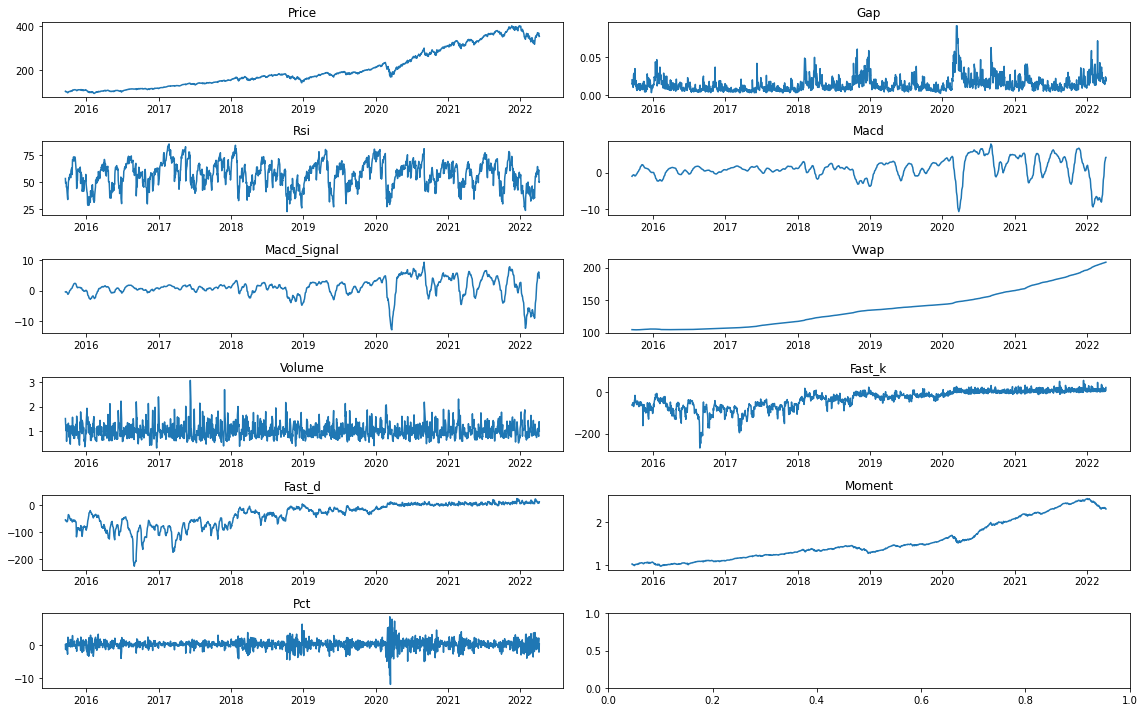

In [5]:
get_rows = lambda x: x // 2 if x % 2 == 0 else x // 2 +1 #행의 수를 결정한다.
rows = get_rows(len(df.columns))
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns, start=1):
        plt.subplot(len(df.columns) // 2 + 1,2,i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

volume은 시간이 지남에 따라 상승하는 경향이 보이므로 이동평균을 통해 나눠준 값을 사용한다.</br>
거래량 = 거래량 / 지난 7일간의 평균 거래량 평균적인 거래량에 비해 얼마나 더 많이 거래가 발생했는지 확인 가능하다.</br>
가격 역시 시간이 지남에 따라 자연히 증가하므로 전일 대비 증감률로 표현해준다.

이렇게 데이터를 변형해 줌으로써 모델은 가격이 시간이 지남에 따라 자연히 증가하는 것이 아니라 학습 할 수 있고 </br>
정확한 가격을 예측하는 것보다 수익률을 예측 함으로써 예측의 난이도를 낮출 수 있다고 기대된다.

In [6]:
volume_mva = df['Volume'].rolling(window = 7).mean()
df['Volume'] = df['Volume'] / volume_mva
df['Pct'] = df['Price'].pct_change()
df = df.apply(lambda x: x.round(3)) #적당히 값을 묶어주기 위해 소수점 3자리를 기점으로 반올림을 진행한다.
df = df.dropna() #결측치를 제거해준다.
df

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
time,,,,,,,,,,,
2015-09-25,97.750,0.027,41.938,-0.619,-0.603,104.334,0.983,-70.126,-61.592,1.004,-0.008
2015-09-28,94.967,0.029,34.768,-0.676,-0.902,104.296,1.068,-52.245,-58.476,0.990,-0.028
2015-09-29,94.473,0.025,33.668,-0.774,-1.165,104.246,1.200,-42.854,-53.269,0.988,-0.005
2015-09-30,96.648,0.014,42.323,-0.856,-1.185,104.216,0.987,-38.596,-48.378,0.998,0.023
2015-10-01,97.085,0.016,43.906,-0.915,-1.151,104.189,0.999,-35.120,-43.959,1.000,0.005
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,361.850,0.014,57.198,2.794,5.561,207.813,0.954,6.198,6.443,2.316,-0.002
2022-04-04,369.300,0.019,61.367,3.452,6.085,207.918,0.813,15.796,9.561,2.325,0.021
2022-04-05,361.100,0.024,55.015,3.916,5.772,208.057,1.068,3.363,7.495,2.313,-0.022


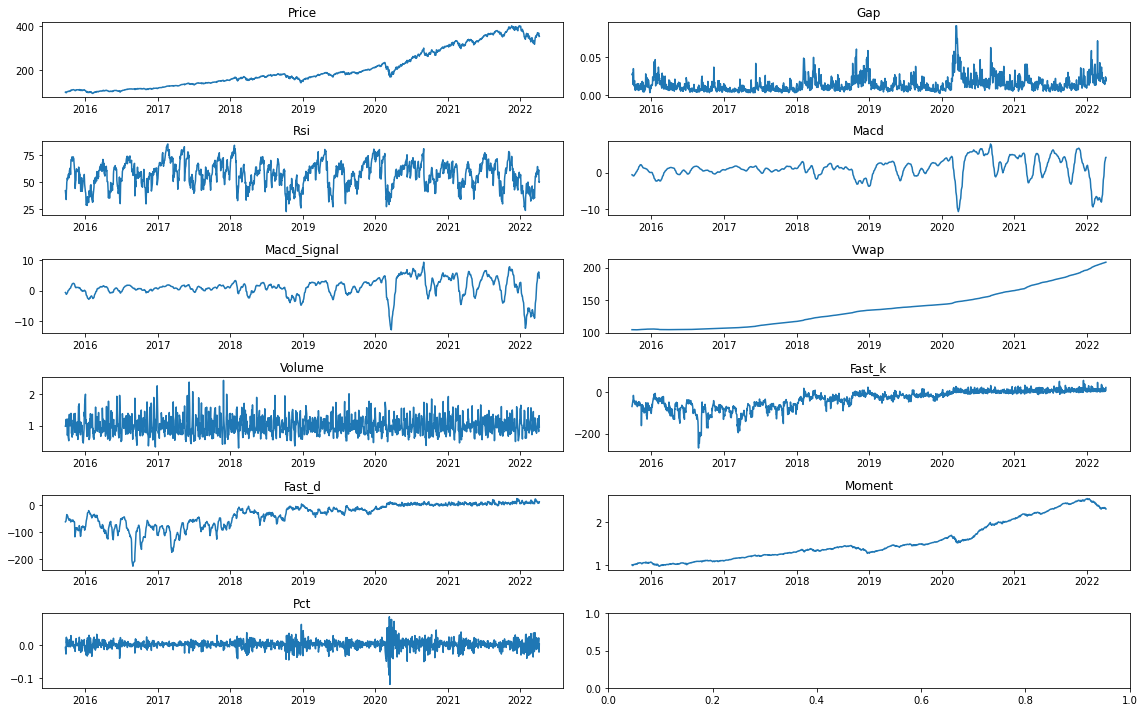

In [7]:
fig, axes = plt.subplots(rows, 2, figsize=(16,10))
for i, c in enumerate(df.columns,start=1):
        plt.subplot(rows, 2, i)
        plt.plot(df[c])
        plt.title(c)
plt.tight_layout()

Volume과 Pct에서 선형성이 사라진 것을 확인 할 수 있다. </br>
이제 모델은 무작정 시간이 지남에 따라 값이 증가한다고 예측하지 못한다.

<AxesSubplot:>

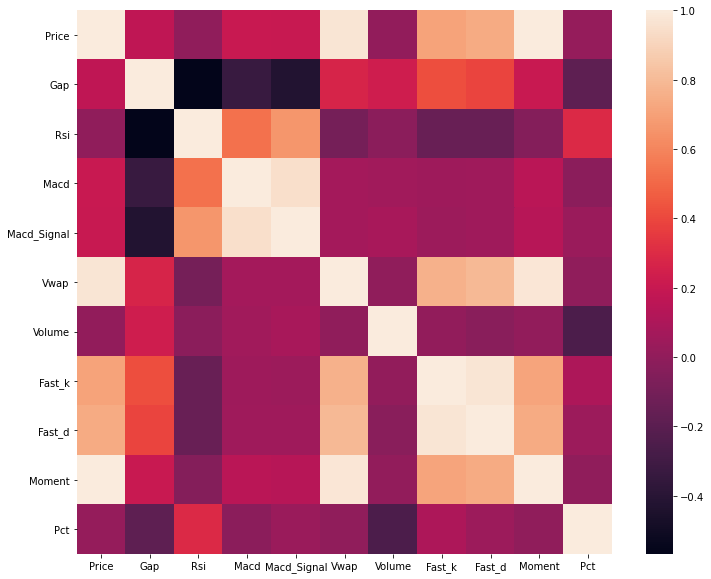

In [8]:
corr = df.corr()
plt.figure(figsize=(12,10))
sns.heatmap(corr)

In [9]:
corr[corr.abs() > 0.3]

,Price,Gap,Rsi,Macd,Macd_Signal,Vwap,Volume,Fast_k,Fast_d,Moment,Pct
Price,1.000000,NaN,NaN,NaN,NaN,0.972854,NaN,0.711053,0.739767,0.997203,NaN
Gap,NaN,1.000000,-0.567838,-0.329298,-0.426676,NaN,NaN,0.423532,0.389664,NaN,NaN
Rsi,NaN,-0.567838,1.000000,0.531926,0.660760,NaN,NaN,NaN,NaN,NaN,NaN
Macd,NaN,-0.329298,0.531926,1.000000,0.945540,NaN,NaN,NaN,NaN,NaN,NaN
Macd_Signal,NaN,-0.426676,0.660760,0.945540,1.000000,NaN,NaN,NaN,NaN,NaN,NaN
Vwap,0.972854,NaN,NaN,NaN,NaN,1.000000,NaN,0.761685,0.792672,0.977803,NaN
Volume,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
Fast_k,0.711053,0.423532,NaN,NaN,NaN,0.761685,NaN,1.000000,0.974240,0.712191,NaN
Fast_d,0.739767,0.389664,NaN,NaN,NaN,0.792672,NaN,0.974240,1.000000,0.740763,NaN
Moment,0.997203,NaN,NaN,NaN,NaN,0.977803,NaN,0.712191,0.740763,1.000000,NaN


price는 vwap,stochastic 지표와 관련이 깊어 보인다. (자명하지만)

RSI와 가격 증감률 간의 상관 관계를 나타내보면 다음과 같다. </br>
어느 정도의 양의 상관 관계를 갖는 것이 보인다.

In [10]:
def plot_corr(x, y, x_name = 'X_feature', y_name = 'y_feature'):
    plt.figure(figsize=(10,10))
    x = (x - x.min()) / (x.max() - x.min())
    y = (y - y.min()) / (y.max() - y.min())
    plt.scatter(x=x, y=y)
    plt.xlabel(x_name)
    plt.ylabel(y_name)

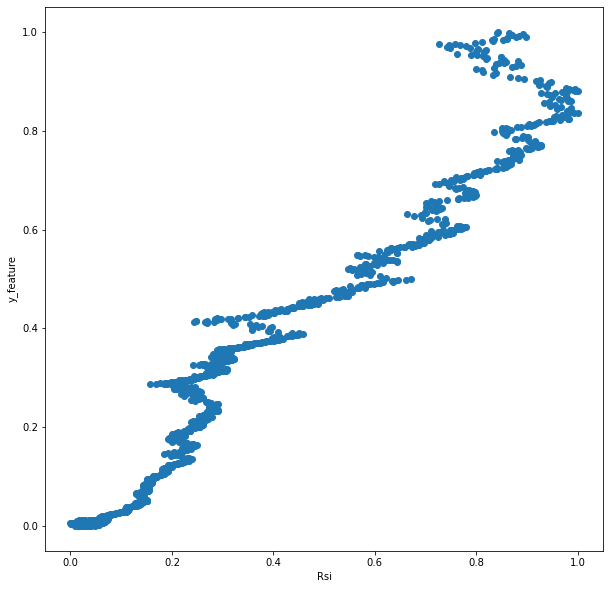

In [11]:
plot_corr(x=df['Price'], y=df['Vwap'], x_name="Rsi")

#### MACD와 가격 증감률 간의 관계를 살펴보자.

MACD는 이평선의 수렴과 발산을 통해 과매수, 과매도를 보여주는 지표이다. 일반적으로 시그널선의 아래에 위치하면 과매도, 시그널 선의 위편에 위치하면 과매수 상태로 여긴다.


In [12]:
def get_cross(graph1, graph2):
    """ 특정한 그래프 2개를 입력받고 
    그래프가 교차되는 지점을 구해줍니다"""
    gap = graph1 - graph2
    buy_sign = []
    sell_sign = []
    for i, g in enumerate(gap.values[1:], start=1):
        if g * gap[i - 1] < 0:
            if g > 0: #차이가 양으로 전환되면 과매수이므로 매도 시그널이다.
                buy_sign.append(gap.index[i]) 
            else:
                sell_sign.append(gap.index[i])
    return buy_sign, sell_sign

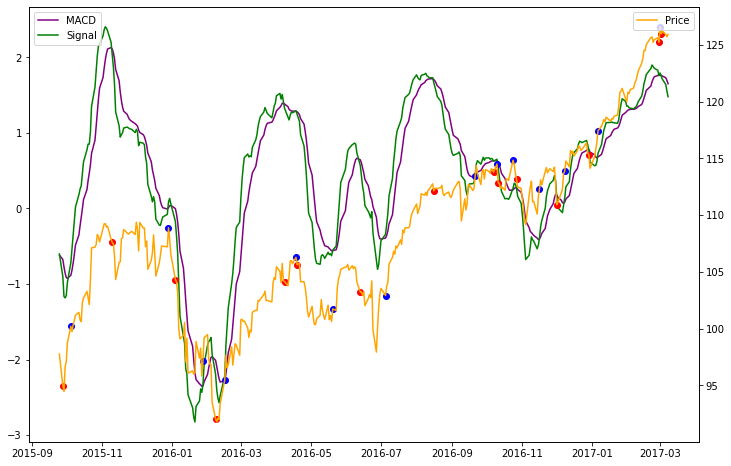

In [13]:
YEAR = 365
fig,ax1 = plt.subplots(figsize=(12,8))
macd_year, signal_year = df['Macd'].iloc[:YEAR], df['Macd_Signal'].iloc[:YEAR]
buy_point, sell_point = get_cross(macd_year, signal_year)
price = df['Price'].iloc[:YEAR]

ax1.plot(macd_year, label='MACD', color='purple')
ax1.plot(signal_year, label='Signal', color='green')
plt.legend(loc="upper left")


ax2 = ax1.twinx()
ax2.plot(price[:365],color='orange',label='Price')
ax2.scatter(buy_point, price.loc[buy_point], marker='o', color='red')
ax2.scatter(sell_point, price.loc[sell_point], marker='o', color='blue')

plt.legend(loc="upper right")

* MACD는 이동평균이라는 정보에 걸맞게 가격의 변동을 원만한 기울기로 추종하고 있다는 것을 확인 할 수 있다. </br>
* Signal과 교차되는 전략을 생각해보면 훌륭하게 들어 맞는다고 볼 수는 없을 것 같다. (빨강: 매수, 파랑: 매도)</br>
하지만 상승, 하락의 신호로 사용하기에는 괜찮은 듯 보인다.


* 피쳐의 관점에선 MACD와 MACD 시그널은 실상 같은 움직임을 보이므로</br>
둘중 하나의 피쳐만 사용하는 쪽이 더 나을 듯 하다. </br>
아니면 시그널과 MACD의 격차만을 피쳐로 사용하는 것도 괜찮아 보인다.

#### 스토캐스틱 지표의 상관관계

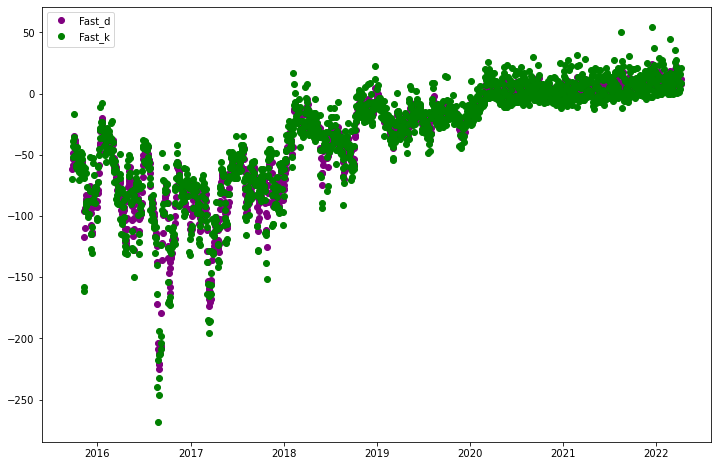

In [14]:
plt.figure(figsize=(12,8))
plt.plot(df['Fast_d'], label='Fast_d', color='purple',linestyle='None',marker='o')
plt.plot(df['Fast_k'], label='Fast_k', color='green',linestyle='None',marker='o')
plt.legend()

Fast_d는 Fast_k를 또 다시 이동평균을 내 활용한 지표이다 보니 값이 전반적으로 안정적이고 극렬하게 튀는 현상이 덜하다.</br>
Fast_k가 가격 증감률과의 상관관계도 더 높지만, 과하게 상태 변화를 받아들이는 값이라는 점에서 </br>
Fast_k보다 Fast_d를 사용하는 쪽이 유리해 보인다.</br>
Fast_k, Fast_d는 상관 계수가 0.7을 넘어가기에 하나만 사용한다.

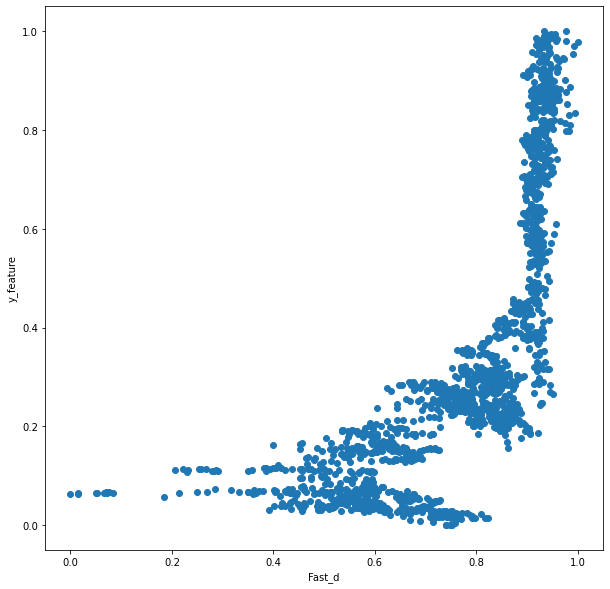

In [15]:
plot_corr(x=df['Fast_d'], y=df['Price'],x_name="Fast_d")

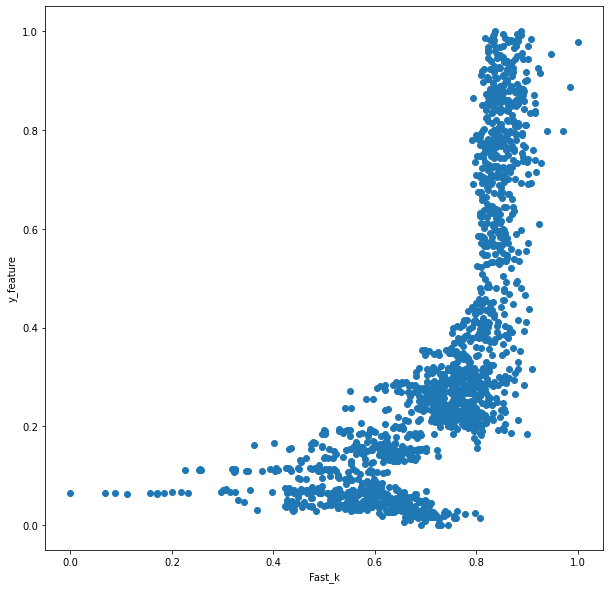

In [16]:
plot_corr(x=df['Fast_k'],y=df['Price'],x_name="Fast_k")

#### 피쳐 선택
다음과 같은 피쳐를 제외하고 모델을 학습 시키기로 했다.
* Price: 대신 가격 증감률을 사용하기로 했다.
* Macd, Macd_Signal: 대신 시그널 - MACD를 사용한다.
* Fast_k: 대신 Fast_d를 사용한다.

In [17]:
macd_gap = df['Macd_Signal'] - df['Macd']
new_df = df.drop(["Macd", "Fast_k"], axis=1)
new_df["Macd_Gap"] = macd_gap
new_df

,Price,Gap,Rsi,Macd_Signal,Vwap,Volume,Fast_d,Moment,Pct,Macd_Gap
time,,,,,,,,,,
2015-09-25,97.750,0.027,41.938,-0.603,104.334,0.983,-61.592,1.004,-0.008,0.016
2015-09-28,94.967,0.029,34.768,-0.902,104.296,1.068,-58.476,0.990,-0.028,-0.226
2015-09-29,94.473,0.025,33.668,-1.165,104.246,1.200,-53.269,0.988,-0.005,-0.391
2015-09-30,96.648,0.014,42.323,-1.185,104.216,0.987,-48.378,0.998,0.023,-0.329
2015-10-01,97.085,0.016,43.906,-1.151,104.189,0.999,-43.959,1.000,0.005,-0.236
...,...,...,...,...,...,...,...,...,...,...
2022-04-01,361.850,0.014,57.198,5.561,207.813,0.954,6.443,2.316,-0.002,2.767
2022-04-04,369.300,0.019,61.367,6.085,207.918,0.813,9.561,2.325,0.021,2.633
2022-04-05,361.100,0.024,55.015,5.772,208.057,1.068,7.495,2.313,-0.022,1.856


* 모멘텀 지표 사용하기

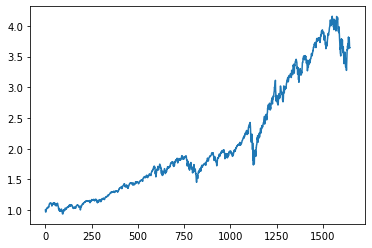

In [18]:
def get_profit(X):
    """수익률을 구해준다."""
    seed = [1]
    for i, v in enumerate(X[1:], start=1):
        seed.append(seed[i - 1] * (1 + v))
    return seed
#수익 곡선을 그려보자.
plt.plot(get_profit(new_df['Pct']))

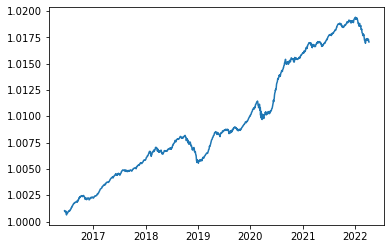

In [19]:
#수익 곡선을 그려보자 비트코인 그래프와 흡사하게 그려진다.
#모멘텀 팩터 만들기
profit = pd.Series(index=new_df.index, data=get_profit(new_df['Pct'] / 100)) #profit은 실제 내 수익률을 보여준다.
m2 = profit.rolling(60).apply(lambda x: x.prod() ** (1.0 / 14)) #2주 간의 기하 평균 수익률
m3 = profit / profit.rolling(90).apply(lambda x: x.prod() ** (1.0 / 30)) #1달 간의 기하 평균 수익률
m6 = profit / profit.rolling(180).apply(lambda x: x.prod() ** (1.0 / 60)) #2달 간의 기하 평균 수익률
momentum = (m2 * 0.5 + m3 * 0.3 + m6 * 0.2).dropna()
plt.plot(momentum)

In [20]:
momentum.name = "Moment"
moment_df = pd.concat([new_df, momentum], axis=1).dropna()
moment_df

,Price,Gap,Rsi,Macd_Signal,Vwap,Volume,Fast_d,Moment,Pct,Macd_Gap,Moment
time,,,,,,,,,,,
2016-06-13,103.222,0.010,45.945,0.566,104.658,1.246,-97.113,1.040,-0.008,-0.077,1.001046
2016-06-14,103.222,0.011,45.945,0.427,104.661,1.128,-102.902,1.039,0.000,-0.173,1.001039
2016-06-15,102.926,0.008,44.090,0.290,104.665,0.977,-112.422,1.038,-0.003,-0.248,1.001012
2016-06-16,103.231,0.015,46.492,0.204,104.668,1.045,-100.585,1.039,0.003,-0.267,1.001012
2016-06-17,102.021,0.014,39.296,0.037,104.670,0.853,-98.236,1.032,-0.012,-0.347,1.000938
...,...,...,...,...,...,...,...,...,...,...,...
2022-04-01,361.850,0.014,57.198,5.561,207.813,0.954,6.443,2.316,-0.002,2.767,1.017216
2022-04-04,369.300,0.019,61.367,6.085,207.918,0.813,9.561,2.325,0.021,2.633,1.017311
2022-04-05,361.100,0.024,55.015,5.772,208.057,1.068,7.495,2.313,-0.022,1.856,1.017197


#### 이상치 확인 해보기
* iqr 범위를 벗어나는 데이터가 몇개 있는지 확인해보자. 
* gap, vwap, macd가 특히 심하다.


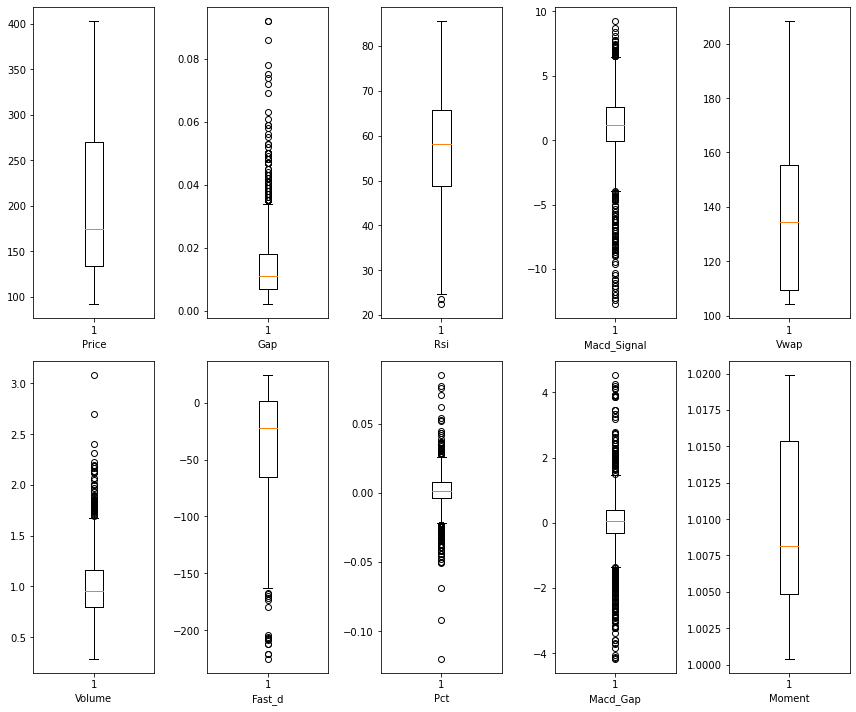

In [57]:
fig,axes = plt.subplots(2,5,figsize=(12,10))
for i, c in enumerate(moment_df.columns,start=1):
    plt.subplot(2,5,i)
    plt.boxplot(moment_df[c])
    plt.xlabel(c)
plt.tight_layout()

In [56]:
from collections import defaultdict
def get_outliers(df):
    """ 
        iqr 범위를 벗어나는 아웃 라이어들의 인덱스를 반환한다.
    """
    q_1 = df.apply(lambda x: np.quantile(x, 0.25))
    q_3 = df.apply(lambda x: np.quantile(x, 0.75))
    iqr = q_3 - q_1
    min_p = q_1 - 1.5 * iqr
    max_p = q_3 + 1.5 * iqr
    outliers = np.where((df < min_p) | (df > max_p))
    row, col = outliers
    outliers_loc = defaultdict(list)
    for r,c in zip(row,col):
        outliers_loc[df.columns[c]].append(r)
    return outliers_loc


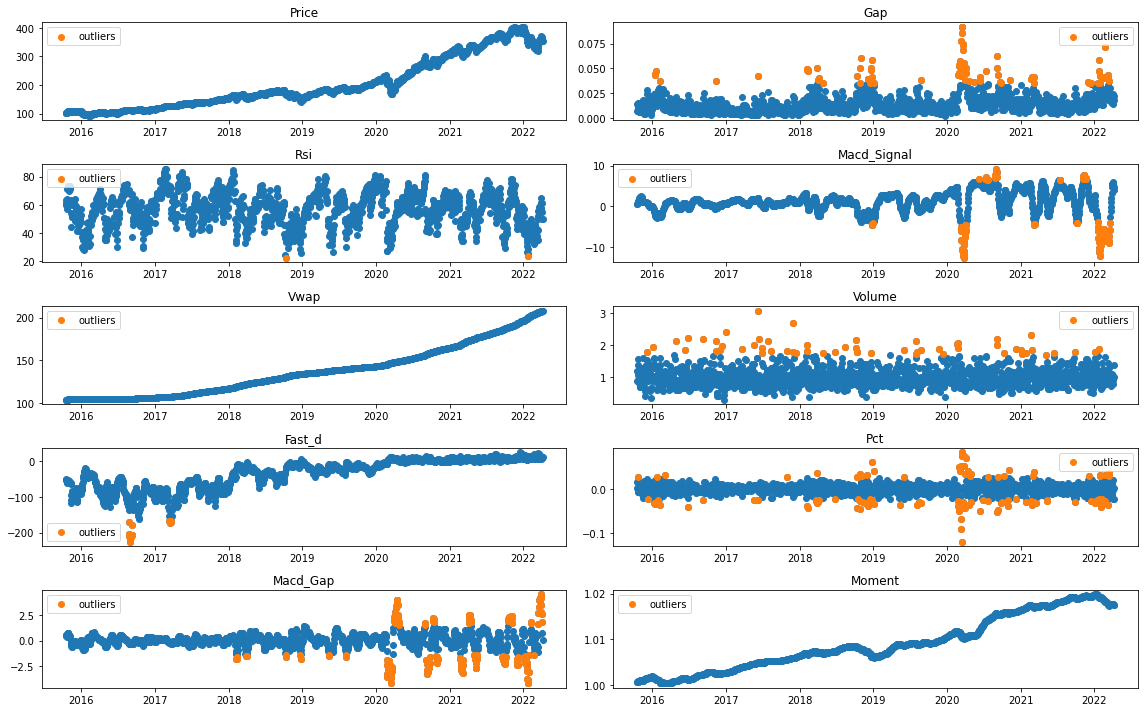

In [58]:
def draw_outlier(outliers_cols, df):
    """ 아웃 라이어들을 피쳐 별로 전부 그려 줍니다"""
    rows = get_rows(len(df.columns))
    fig, axes = plt.subplots(rows, 2, figsize=(16,10))
    for i, c in enumerate(df.columns,start=1):
        index = df[c].index
        plt.subplot(rows,2,i)
        plt.title(c)
        plt.scatter(x=index,y=df[c])
        plt.scatter(x=df[c].iloc[outliers_cols[c]].index, y=df[c].iloc[outliers_cols[c]],label='outliers')
        plt.legend()
    plt.tight_layout()

outliers_cols = get_outliers(moment_df)
draw_outlier(outliers_cols, moment_df)

피쳐별로 아웃라이어를 모조리 제거해 주기에는 문제가 있다. </br>
RSI에서 잡힌 아웃라이어 정도만 제거해준다.

In [59]:
for k, v in outliers_cols.items():
    print(f"{k}: {len(v)}")

Pct: 120
Volume: 57
Gap: 79
Fast_d: 16
Macd_Gap: 180
Rsi: 2
Macd_Signal: 101
Price: 0
Vwap: 0
Moment: 0


<AxesSubplot:>

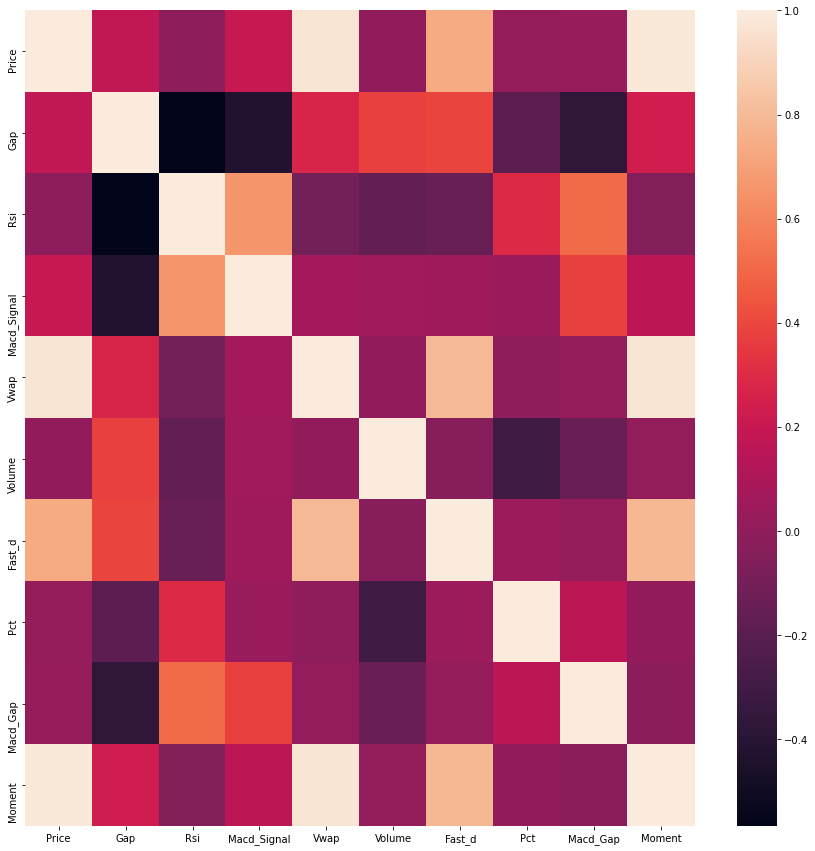

In [60]:
corr = moment_df.corr()
plt.figure(figsize=(15,15))
sns.heatmap(corr)

모멘트 팩터는 RSI, MACD 등 다른 모멘텀과 연관된 피쳐와 깊은 상관 관계를 보인다.

모델을 생성하고 비교해보자.

In [48]:
ridge_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=False)),
    ('min_max',MinMaxScaler()),
    ('regulator', Ridge(alpha=10,solver="sag",random_state=42,fit_intercept=True))
])

lasso_model = Pipeline([
    ("poly_features",PolynomialFeatures(degree=1, include_bias=True)),
    ('min_max',MinMaxScaler()),
    ('regulator', Lasso(alpha=10,random_state=42,fit_intercept=True))
])

rf_model = Pipeline([
    ('min_max',MinMaxScaler()),
    ('model',RandomForestRegressor(bootstrap=True, random_state=42, oob_score=True, max_depth=200))
])

In [32]:
def create_train_data(df):
    """ 트레이닝 데이터를 생성한다. 
        다음날 데이터를 예측 해야 하므로 한 칸씩 미뤄주고 댕겨준다.
    """
    X = df.drop(['Price'], axis=1).iloc[1:]
    y = df['Price'].iloc[:-1]
    train_X, test_X, train_y, test_y = train_test_split(X, y, test_size=0.3, random_state=42)
    return train_X, test_X, train_y, test_y

In [49]:
train_X, test_X, train_y, test_y = create_train_data(moment_df)
ridge_model.fit(train_X, train_y)
lasso_model.fit(train_X, train_y)

Pipeline(steps=[('poly_features', PolynomialFeatures(degree=1)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=10, random_state=42))])

In [50]:
def plot_coef(coef, index, intercept=False):
    if intercept:
        index = index.insert(0, "Intercept")
    coef_df = pd.DataFrame(data=coef,index=index,columns=["Coef"])
    coef_df.plot.bar()


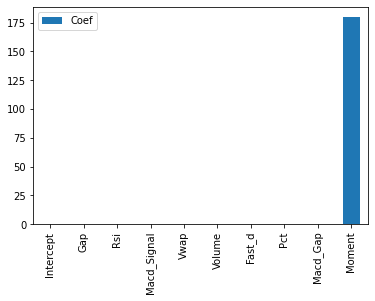

In [51]:
plot_coef(lasso_model['regulator'].coef_, train_X.columns, True)

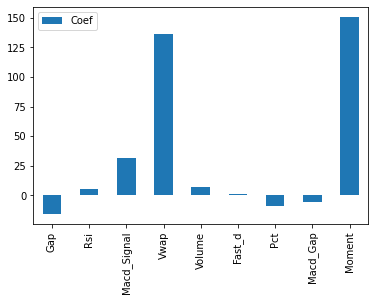

In [53]:
plot_coef(ridge_model['regulator'].coef_, train_X.columns)


* 모멘텀과  VWAP만으로 예측을 진행한다고 하여도 과언이 아니다.

In [34]:
def find_best_alpha(train_X, train_y, test_X, test_y, model):
    """파라미터 값을 변경해가며 알파 값을 바꿔본다."""
    best_alpha = 1
    best_mse = float('inf')
    for i in [1000,300,100,30,10,1]:
        model.set_params(regulator__alpha=i)
        model.fit(train_X, train_y)
        pred = model.predict(test_X)
        mse = ((test_y - pred) ** 2).mean()
        if best_mse > mse:
            best_mse = mse
            best_alpha = i
        print(f'mse: {mse}, alpha: {i}')
    return best_alpha
    
r_alpha = find_best_alpha(train_X, train_y, test_X, test_y, ridge_model)
ridge_model.set_params(regulator__alpha=r_alpha)
ridge_model.fit(train_X, train_y)

l_alpha = find_best_alpha(train_X, train_y, test_X, test_y, lasso_model)
lasso_model.set_params(regulator__alpha=l_alpha)
lasso_model.fit(train_X, train_y)



mse: 1662.662560274307, alpha: 1000
mse: 551.4430826604183, alpha: 300
mse: 217.3603457845038, alpha: 100
mse: 106.36313517562111, alpha: 30
mse: 73.08636161828223, alpha: 10
mse: 33.97402903727004, alpha: 1
mse: 7440.7391838216045, alpha: 1000
mse: 7440.7391838216045, alpha: 300
mse: 7440.7391838216045, alpha: 100
mse: 7440.7391838216045, alpha: 30
mse: 1220.5209649571673, alpha: 10
mse: 141.94453581472072, alpha: 1


/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2104.484490712406, tolerance: 903.9136978905935
  model = cd_fast.enet_coordinate_descent(
/Users/jin/opt/anaconda3/envs/py_3.8/lib/python3.8/site-packages/sklearn/linear_model/_coordinate_descent.py:529: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 2104.484490712406, tolerance: 903.9136978905935
  model = cd_fast.enet_coordinate_descent(


Pipeline(steps=[('poly_features', PolynomialFeatures(degree=3)),
                ('min_max', MinMaxScaler()),
                ('regulator', Lasso(alpha=1, random_state=42))])

In [35]:
def visualize(pred,target,name):
    plt.figure(figsize=(20,12))
    index = np.arange(len(target))
    plt.scatter(index, target,label='target')
    plt.scatter(index, pred,label='model')
    mse = np.mean((target - pred) ** 2)
    plt.suptitle(f'{name}',fontsize=20)
    plt.title(f'MSE is {mse*100:.3f}')
    plt.legend()

In [36]:
r_pred = ridge_model.predict(test_X)
l_pred = lasso_model.predict(test_X)

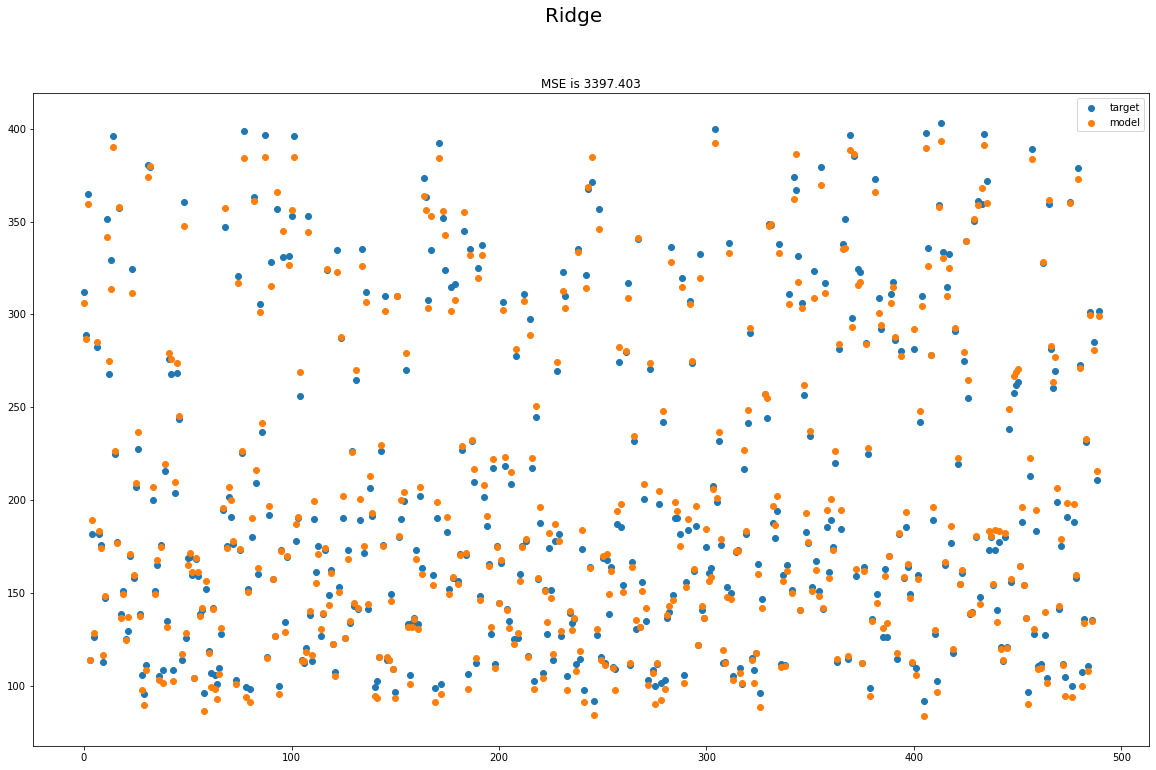

In [37]:
visualize(r_pred,test_y,"Ridge")

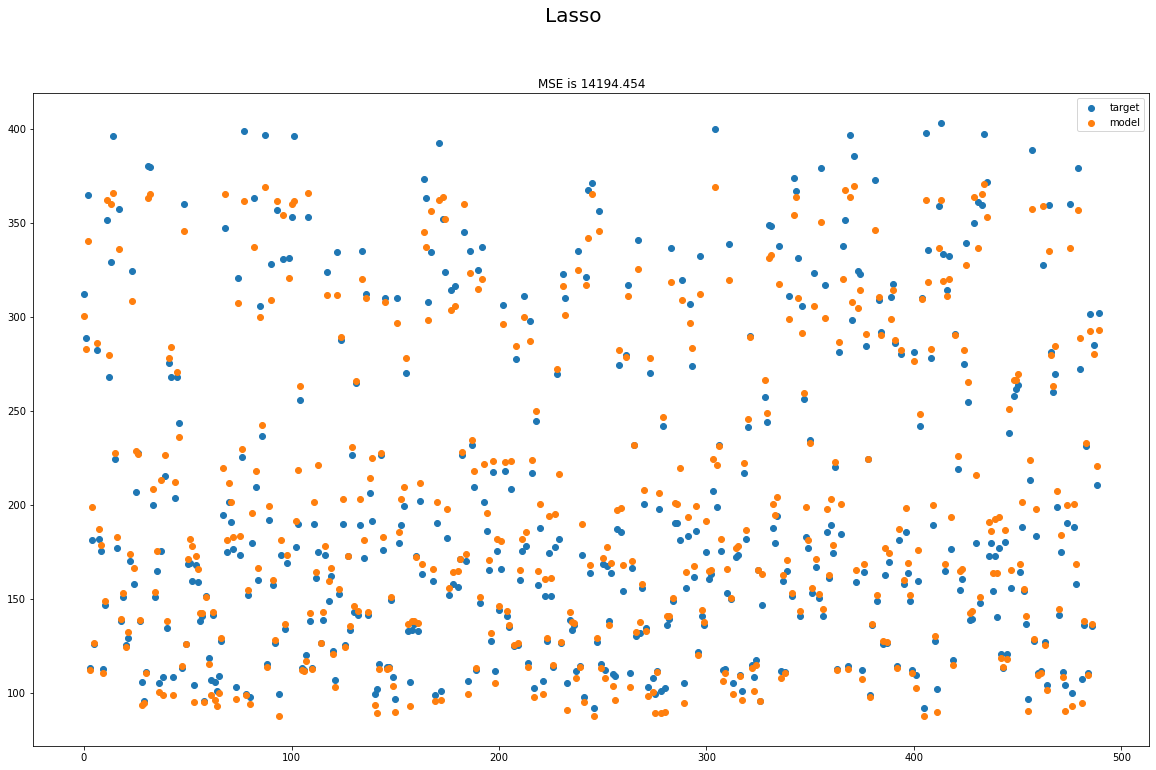

In [38]:
visualize(l_pred, test_y, "Lasso")

In [39]:
def visualize_plot(pred, target, name):
    """ 예측한 증감률과 실제 증감률을 활용해 수익 곡선을 그려준다."""
    target_profit = get_profit(target)
    pred_profit = get_profit(pred)
    plt.figure(figsize=(12,10))
    plt.plot(target_profit, label='target')
    plt.plot(pred_profit, label='pred')
    plt.title(name)
    plt.legend()

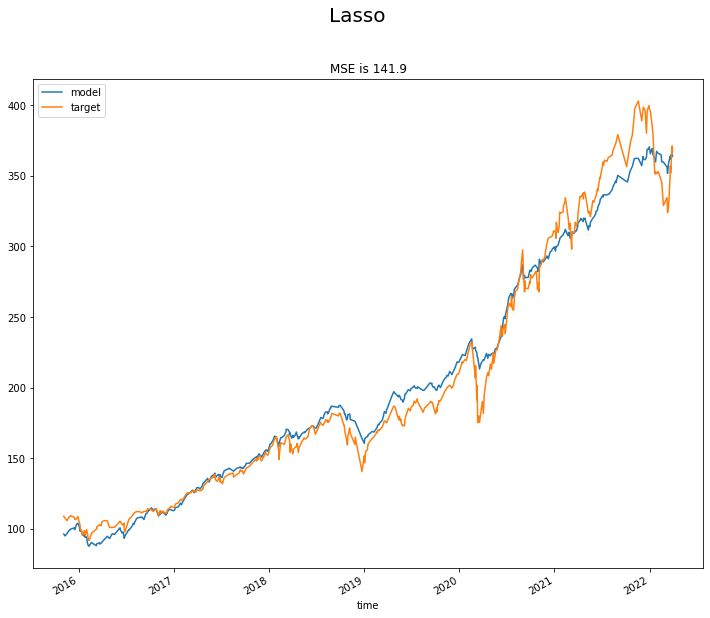

In [42]:
eval_model.visualize_plot(l_pred, test_y, "Lasso")

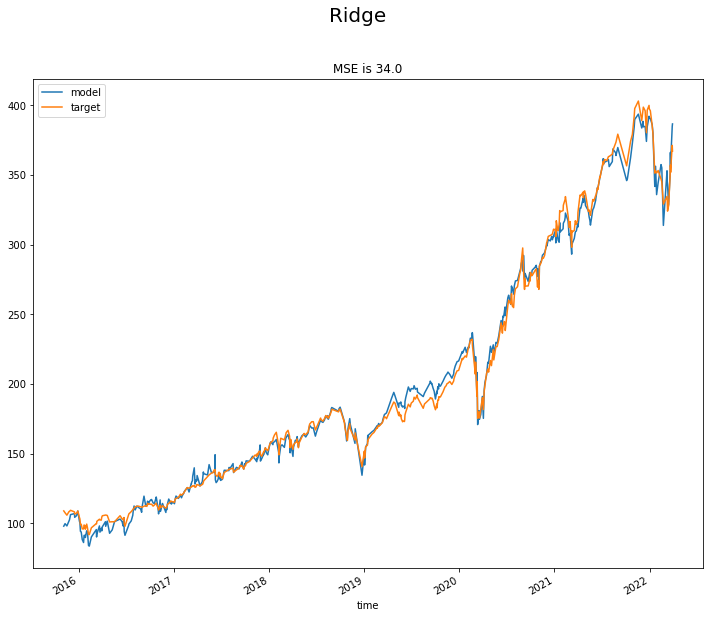

In [43]:
eval_model.visualize_plot(r_pred, test_y, "Ridge")

In [44]:
rf_model.fit(train_X, train_y)
rf_pred = rf_model.predict(test_X)

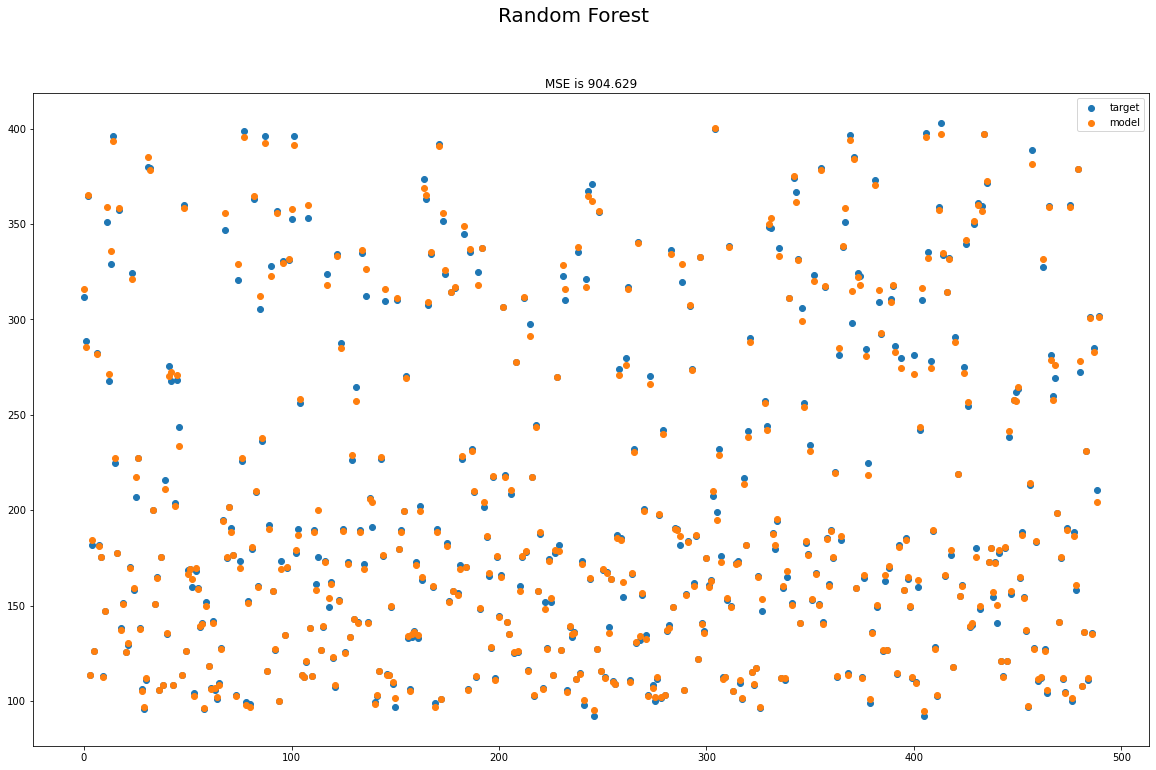

In [45]:
visualize(rf_pred, test_y, "Random Forest")

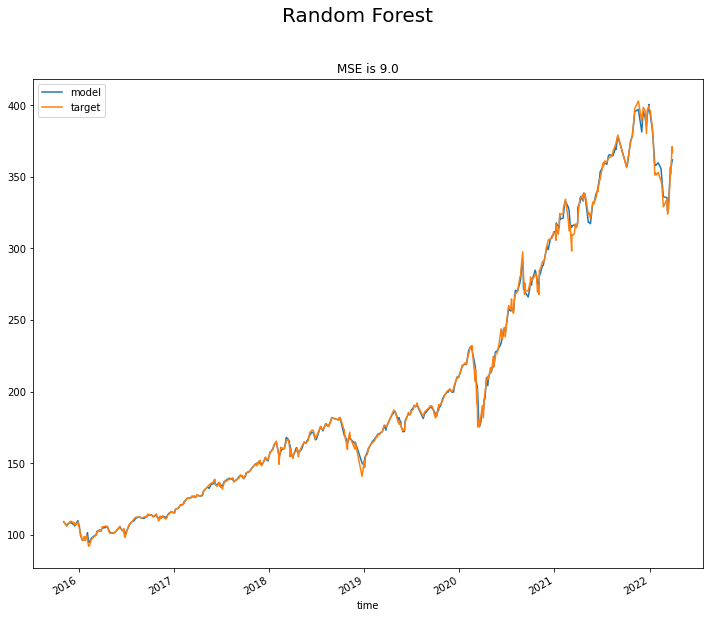

In [47]:
eval_model.visualize_plot(rf_pred, test_y, "Random Forest")